**Imports Libraries**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor

**Load Data**

In [74]:
personal_df = pd.read_excel(r'/content/Medibuddy insurance data personal details (1) (2).xlsx')
price_df = pd.read_excel(r'/content/Medibuddy Insurance Data Price (1) (2).xlsx')

**Clean Column Names**

In [75]:
personal_df.columns = personal_df.columns.str.strip().str.lower().str.replace(" ", "_")
price_df.columns = price_df.columns.str.strip().str.lower().str.replace(" ", "_")

**Merge**

In [76]:
data = pd.merge(personal_df, price_df, on="policy_no.", how="inner")

**Label Encoding for Categorical Features**

In [77]:
label_encoders = {}
for col in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le



**Train-Test Split**

In [78]:
X = data.drop(columns=["charges_in_inr"])
y = data["charges_in_inr"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Feature Scaling**

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**EDA**

🔍 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   policy_no.      1338 non-null   int64  
 1   children        1338 non-null   int64  
 2   smoker          1338 non-null   int64  
 3   region          1338 non-null   int64  
 4   age             1338 non-null   int64  
 5   sex             1338 non-null   int64  
 6   bmi             1338 non-null   float64
 7   charges_in_inr  1338 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 83.8 KB
None

📈 Correlation Heatmap:


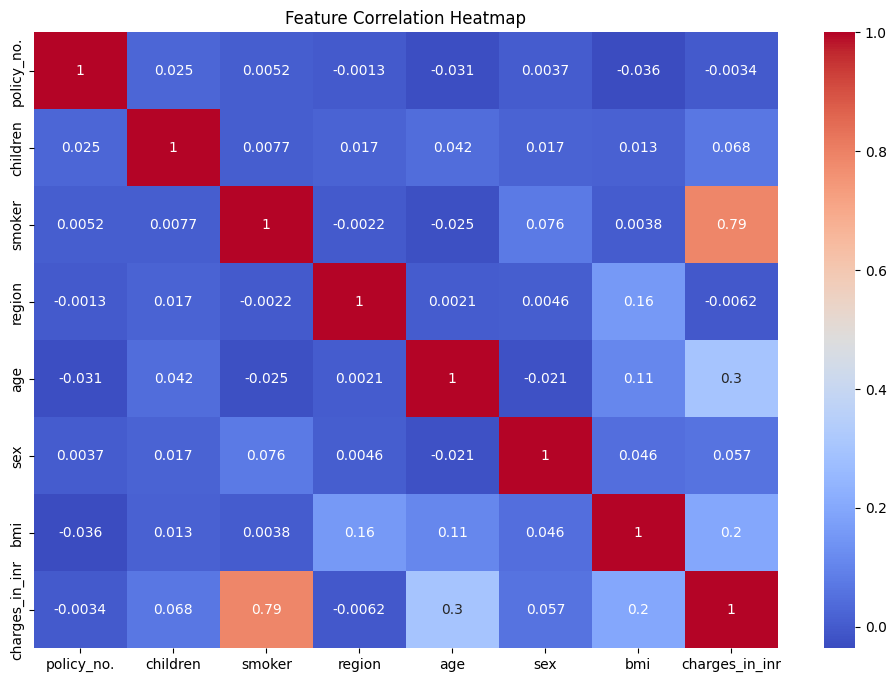

In [80]:

numeric_data = data.select_dtypes(include=np.number)

print("🔍 Data Info:")
print(data.info())

print("\n📈 Correlation Heatmap:")
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

**Model Evaluation Function**

In [81]:
def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n📘 {name}")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.4f}")

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title(f"{name} - Actual vs Predicted")
    plt.show()
    return {
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    }



**Models**

In [82]:
models = [
    (LinearRegression(), "Linear Regression"),
    (Ridge(), "Ridge Regression"),
    (Lasso(), "Lasso Regression"),
    (DecisionTreeRegressor(), "Decision Tree"),
    (RandomForestRegressor(n_estimators=100), "Random Forest"),
    (GradientBoostingRegressor(), "Gradient Boosting"),
    (SVR(), "Support Vector Regressor"),
    (XGBRegressor(n_estimators=100, objective="reg:squarederror"), "XGBoost")
]

results = []


**Train and Evaluate Each Model**


📘 Linear Regression
MAE: 4219.36, MSE: 38364776.31, R2: 0.7300


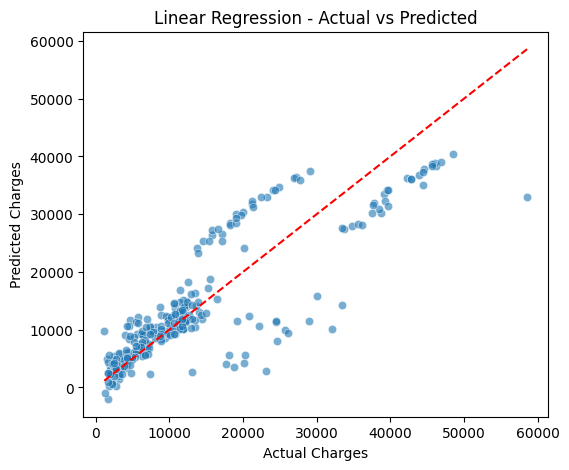


📘 Ridge Regression
MAE: 4220.16, MSE: 38356609.29, R2: 0.7301


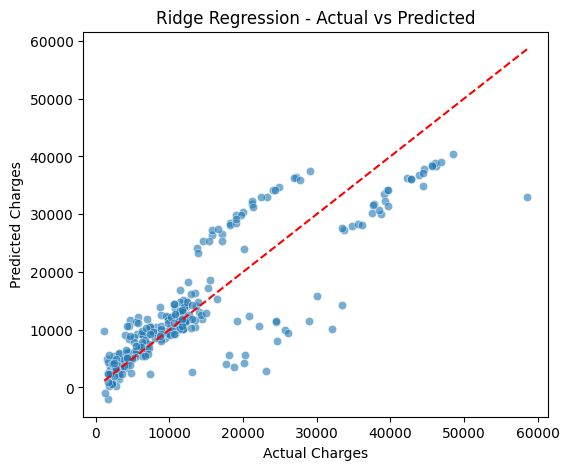


📘 Lasso Regression
MAE: 4219.24, MSE: 38365411.42, R2: 0.7300


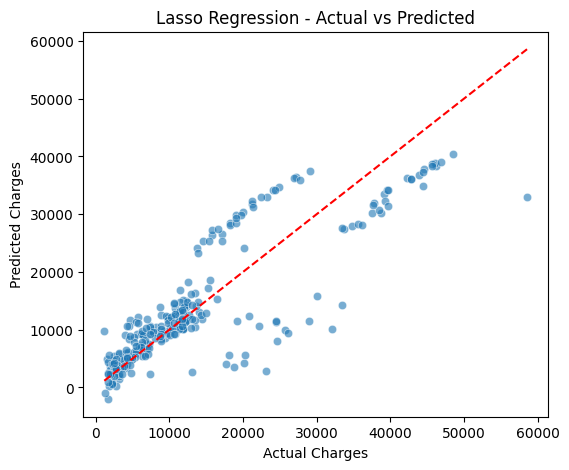


📘 Decision Tree
MAE: 2822.09, MSE: 35420957.72, R2: 0.7507


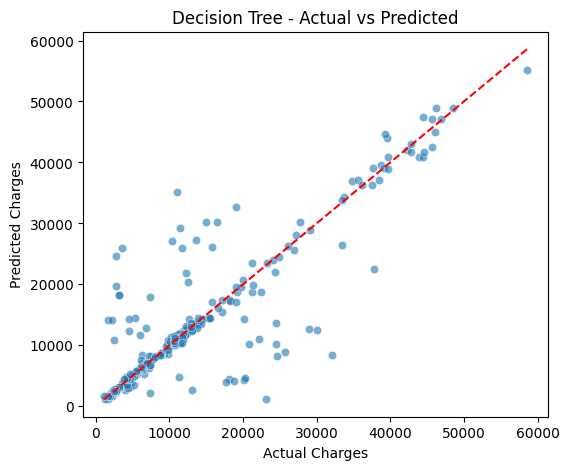


📘 Random Forest
MAE: 2635.72, MSE: 21666463.36, R2: 0.8475


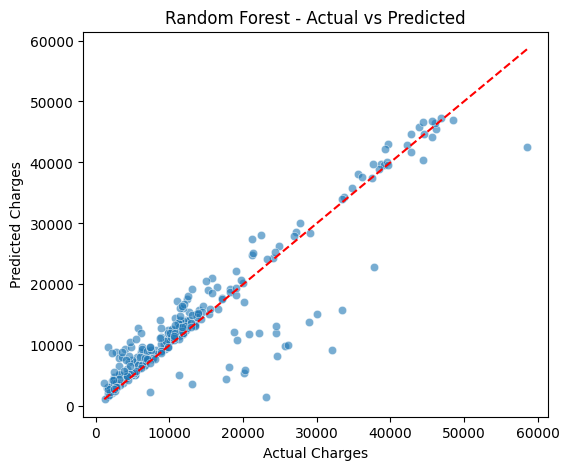


📘 Gradient Boosting
MAE: 2366.53, MSE: 19148449.36, R2: 0.8652


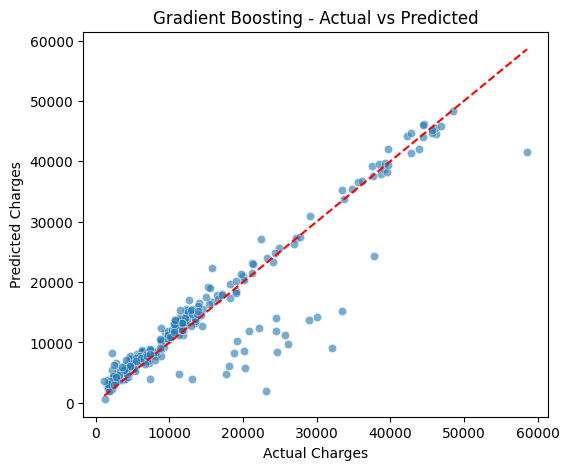


📘 Support Vector Regressor
MAE: 8384.98, MSE: 160430288.49, R2: -0.1290


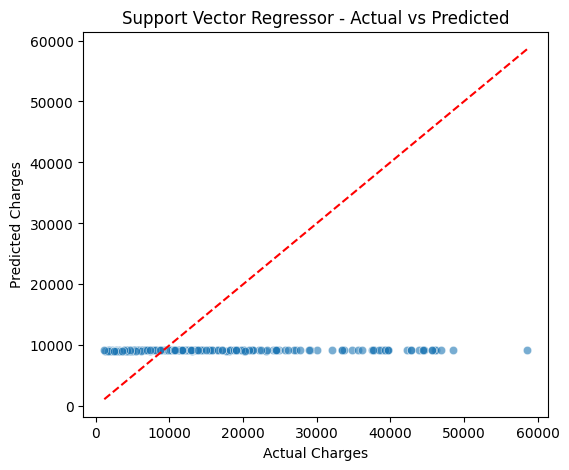


📘 XGBoost
MAE: 2743.31, MSE: 23190293.60, R2: 0.8368


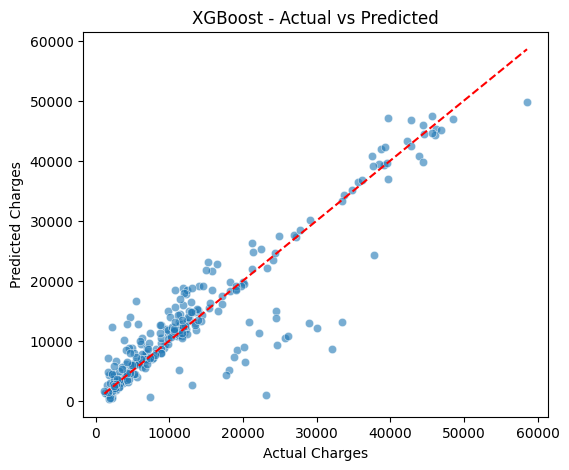

In [83]:
for model, name in models:
    result = evaluate_model(model, name)
    results.append(result)

**Compare Model Performance**

In [84]:
result_df = pd.DataFrame(results)
fig = px.bar(result_df, x="Model", y="R2", title="Model R² Scores Comparison", color="Model")
fig.show()

**Feature Importance (for Random Forest)**

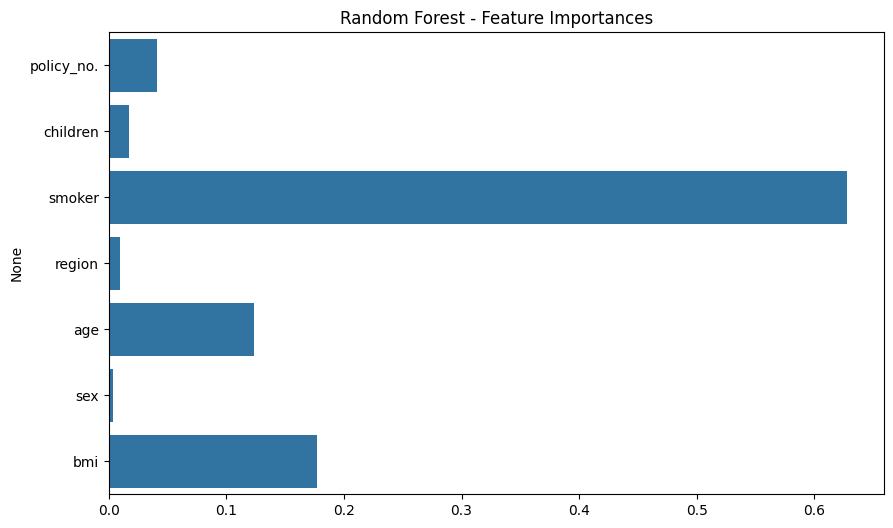

In [85]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title("Random Forest - Feature Importances")
plt.show()

**Final Score Summary for All Models**

In [86]:
print("\n Final Score Summary:")
final_scores = pd.DataFrame(results)
print(final_scores.sort_values(by="R2", ascending=False).to_string(index=False))


 Final Score Summary:
                   Model         MAE          MSE        R2
       Gradient Boosting 2366.532043 1.914845e+07  0.865244
           Random Forest 2635.724295 2.166646e+07  0.847524
                 XGBoost 2743.307279 2.319029e+07  0.836800
           Decision Tree 2822.088716 3.542096e+07  0.750727
        Ridge Regression 4220.155967 3.835661e+07  0.730068
       Linear Regression 4219.364354 3.836478e+07  0.730011
        Lasso Regression 4219.239505 3.836541e+07  0.730006
Support Vector Regressor 8384.981586 1.604303e+08 -0.129017
